#This model uses LSTM to predict a Daily share price movements based on time series and batches of 60 days

# Read the CSV and Perform Basic Data Cleaning

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
df_stock1 = pd.read_csv("../static/data/cba.csv")
# Drop the null columns where all values are null
df_stock2 = df_stock1.dropna(axis='columns', how='all')
# Drop the null rows
df_stock3 = df_stock2.dropna()
# Drop the last rows to test prediction to actual
df_stock_less1= df_stock3.iloc[:-1,:]
# Drop last 3 columns sentiment RBA FED
N=3
df = df_stock_less1.iloc[: , :-N]
df_stock_less1.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED,CPI,CPIUS,CPIchange
0,3/01/2000,26.088652,26.088652,26.088652,26.088652,7.993308,0,NEGATIVE,5.0,5.5,69.7,168.8,2.8
1,4/01/2000,26.058813,26.058813,25.720646,25.790268,7.901886,1018072,NEGATIVE,5.0,5.5,69.7,168.8,2.8
2,5/01/2000,25.353634,25.392424,25.113932,25.213392,7.725136,2191283,NEGATIVE,5.0,5.5,69.7,168.8,2.8
3,6/01/2000,25.362585,25.362585,24.666357,24.716087,7.572770,1505531,POSITIVE,5.0,5.5,69.7,168.8,2.8
4,7/01/2000,24.913021,25.113932,24.735979,24.964741,7.648952,1414040,POSITIVE,5.0,5.5,69.7,168.8,2.8


In [4]:
import pandas as pd
df_cba = pd.read_csv("../static/data/cba.csv")
df_cba = df_cba.dropna()
df_cba = df_cba.iloc[0:60,:6]
df_cba.tail(5)

,Date,Open,High,Low,Close,Adj Close
55,20/03/2000,22.876057,22.965572,22.746758,22.866112,7.160458
56,21/03/2000,22.876057,22.876057,22.488159,22.547834,7.060788
57,22/03/2000,22.677135,22.756704,22.527943,22.537889,7.057676
58,23/03/2000,22.655252,22.726866,22.329021,22.428482,7.023416
59,24/03/2000,22.428482,22.567728,22.239506,22.507055,7.048021


In [5]:
cba_json = df_cba.to_json(orient='records')
# print(cba_json)

In [6]:
cba_dict = df_cba.to_dict(orient='records')
# print(cba_dict)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5722 entries, 0 to 5721
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5722 non-null   object 
 1   Open       5722 non-null   float64
 2   High       5722 non-null   float64
 3   Low        5722 non-null   float64
 4   Close      5722 non-null   float64
 5   Adj Close  5722 non-null   float64
 6   Volume     5722 non-null   int64  
 7   SENTIMENT  5722 non-null   object 
 8   RBA        5722 non-null   float64
 9   FED        5722 non-null   float64
dtypes: float64(7), int64(1), object(2)
memory usage: 491.7+ KB


In [8]:
data = df.filter(['Close'])
dataset = data.values
dataset.shape


(5722, 1)

# # Pre-processing : Scale the data using the MinMaxScaler and split train data

In [9]:
# Scale your data
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
dataset_scaled = scaler.fit_transform(dataset)

# Split into train or test
import math
train_data_len = math.ceil(len(dataset)*.8)
train_data = dataset_scaled[0:train_data_len,:]
train_data.shape


(4578, 1)

In [10]:
X_train = []
y_train = []

for i in range (60, len(train_data)):
    X_train.append(train_data[i-60:i,0]) # contains 60 values
    y_train.append(train_data[i,0])   # contains 61st value
    if i<= 60:
        print(X_train)
        print(y_train) 


[array([0.04184307, 0.03844119, 0.03186422, 0.02619443, 0.02902934,
       0.03583307, 0.03112717, 0.0329982 , 0.03073027, 0.03450637,
       0.0379876 , 0.03712579, 0.03129727, 0.03469913, 0.03390536,
       0.03469913, 0.0329982 , 0.0329982 , 0.03776081, 0.04218326,
       0.04036892, 0.03544755, 0.03531146, 0.03016329, 0.03424555,
       0.03549291, 0.03408679, 0.03696705, 0.04090187, 0.0449728 ,
       0.04610676, 0.05227547, 0.04921377, 0.04036892, 0.04110597,
       0.03708043, 0.0399607 , 0.04127609, 0.03932567, 0.03889476,
       0.03056017, 0.02780467, 0.03696705, 0.03526612, 0.03062821,
       0.02789536, 0.0244935 , 0.0244935 , 0.0244935 , 0.00521622,
       0.00657697, 0.00635016, 0.01099939, 0.0086521 , 0.00521622,
       0.00510283, 0.00147414, 0.00136076, 0.00011341, 0.00100922])]
[0.002086477591719982]


# Prepare train data for LSTM model

In [11]:
# Convert list to numpy array for LSTM model:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(4518, 60)

In [12]:
# LSTM model expects 3D, reshape:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(4518, 60, 1)

# Build the LSTM model

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [14]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
model.fit(X_train, y_train, batch_size=1, epochs=1)

4518/4518 [==============================] - 94s 20ms/step - loss: 6.3604e-04


In [16]:
#Create test data
test_data = dataset_scaled[train_data_len-60:,:]
X_test = []
y_test = dataset[train_data_len:,:]
for i in range(60, len(test_data)):
 X_test.append(test_data[i-60:i,0])

In [17]:
#Covert test data to a numpy array and reshape
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

In [18]:
#Get predicted prices
predictions_lstm = model.predict(X_test)
predictions = scaler.inverse_transform(predictions_lstm)

In [19]:
#Get the root mean square error (RMSE) 0 being most favourable
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

1.9260523727009382

In [20]:
# date_time = df["Date"]
# date_time = pd.to_datetime(date_time)
# data = data.set_index(date_time)

C:\Users\antoi\AppData\Local\Temp/ipykernel_28420/2788820419.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


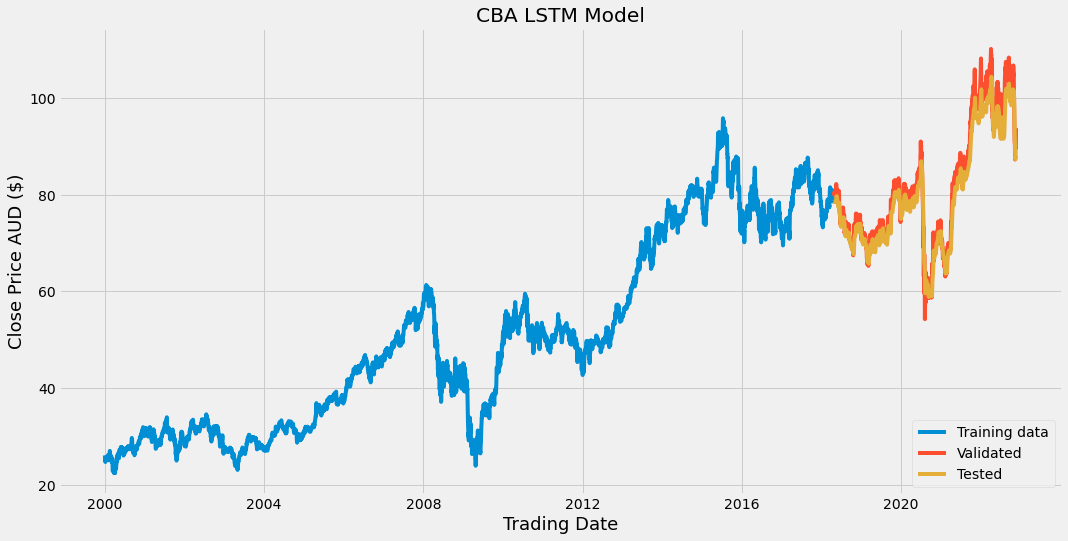

In [21]:
#Plot the data to validate the test data
plt.style.use('fivethirtyeight')
train = data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = data.iloc[train_data_len:] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test

plt.figure(figsize=(16,8))
plt.title('CBA LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training data','Validated','Tested'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/cba_graph.png')
plt.show()


# Test data Predictions on the Model

In [22]:
valid['Difference']= valid['Close']-valid['Predictions']
valid

C:\Users\antoi\AppData\Local\Temp/ipykernel_28420/3952761259.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Difference']= valid['Close']-valid['Predictions']


,Close,Predictions,Difference
4578,79.940002,78.572578,1.367424
4579,80.010002,78.554398,1.455604
4580,80.300003,78.492447,1.807556
4581,80.570000,78.495163,2.074837
4582,79.809998,78.577507,1.232491
...,...,...,...
5717,89.669998,87.413918,2.256080
5718,89.570000,87.349510,2.220490
5719,89.750000,87.529854,2.220146
5720,90.160004,87.775307,2.384697


In [23]:
#Get latest 60 quotes less 1 to predict:

#import pandas_datareader.data as web
#symbol = 'CBA.AX'
#stock_quote = web.DataReader(symbol,data_source='yahoo',start='2022-01-01', end='2022-04-13')
#stock_quotes_sixty = stock_quotes_sixty.filter(['Close'])
#stock_quotes_sixty
#OR use csv data 

In [24]:
# Use last 60 days price on model to predict next days price
stock_quotes_sixty = df_stock_less1.tail(60)
stock_close_sixty = stock_quotes_sixty['Close']
last_60_days_val = stock_close_sixty[-60:].values
last_60_days = last_60_days_val.reshape(-1,1)
last_60_days.shape

(60, 1)

In [25]:
last_60_days_scaled = scaler.transform(last_60_days)
X_tell = []
X_tell.append(last_60_days_scaled)
X_tell =np.array(X_tell)
X_tell =np.reshape(X_tell, (X_tell.shape[0], X_tell.shape[1],1))
X_tell.shape

(1, 60, 1)

In [26]:
pred_price = model.predict(X_tell)
pred_price = scaler.inverse_transform(pred_price)
pred_price = int(pred_price)
print(f'Predicted next day share price {pred_price}')

Predicted next day share price 89


In [27]:
#stock_quote_acual = web.DataReader('CBA.AX',data_source='yahoo',start='2022-04-14', end='2022-04-14')
#OR get last quote from latest csv
stock_quote_last_one = df_stock1.tail(1)
stock_quote_last_one

,Date,Open,High,Low,Close,Adj Close,Volume,SENTIMENT,RBA,FED,CPI,CPIUS,CPIchange
5722,28/06/2022,93.989998,94.300003,93.099998,93.540001,93.540001,2486253,POSITIVE,0.85,1.75,125.0,288.94152,3.5


In [28]:
#save actual to variable
actual_price = stock_quote_last_one.iloc[0,4]
actual_date = stock_quote_last_one.iloc[0,0] 
actual_price = int(actual_price)
actual_price
actual_date

'28/06/2022'

# Save the Model

In [29]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
filepath = '../static/cba_model.sav'
model.save(filepath, save_format="h5")

#Save last 60 days to a list cba_sixty and load df

In [30]:
#PREDICT USING LOADED MODEL

In [31]:
from keras.models import load_model

In [32]:
model_in = load_model('../static/cba_model.sav')

In [33]:
df_cba = pd.read_csv("../static/data/cba.csv")
df_cba = df_cba.dropna()
cbadump_sixty = df_cba.iloc[-4250:]
sixty_val = cbadump_sixty.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)
last_sixty.shape

(60, 1)

#Create a function to loop through the days input

In [34]:
from keras.models import load_model
model_in = load_model('../static/cba_model.sav')
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

# Read in the CSV file

cbadump_sixty = pd.read_csv("../static/data/cba.csv")
cbadump_sixty = cbadump_sixty.dropna()
cbadump_sixty = cbadump_sixty.iloc[-4250:]
sixty_val = cbadump_sixty.iloc[-60:,4].values
last_sixty = sixty_val.reshape(-1,1)

price_list=[]

#Function to predict future days predicted price, in loop
input = 100 #days
if input == "":
    input = 100
else:
   input = int(input)

def predict_cba(last_sixty,model_in,input):
    for i in range(0, input):

        #Takes df and converts to model's predict shape
        last_sixty_scaled = scaler.fit_transform(last_sixty)
        new_X_tell = []
        new_X_tell.append(last_sixty_scaled)
        new_X_tell =np.array(new_X_tell)
        new_X_tell =np.reshape(new_X_tell, (new_X_tell.shape[0], new_X_tell.shape[1],1))
        
        model_in_pd_scale = model_in.predict(new_X_tell)
        model_in_price = scaler.inverse_transform(model_in_pd_scale) # New price predicted

        last_sixty_less_one = np.delete(last_sixty, 0, 0)
        last_sixty = np.append(last_sixty_less_one, model_in_price,axis = 0) # Update last 60
        print(i)
        print("Day finished! Price: ")
        price_float = float(model_in_price)
        price = round(price_float, 2)
        price_list.append(price)
    else:
        print("Could not predict further!")
        print(input)
    print(price_list)
   

In [35]:
predict_cba(last_sixty,model_in,input)

0
Day finished! Price: 
1
Day finished! Price: 
2
Day finished! Price: 
3
Day finished! Price: 
4
Day finished! Price: 
5
Day finished! Price: 
6
Day finished! Price: 
7
Day finished! Price: 
8
Day finished! Price: 
9
Day finished! Price: 
10
Day finished! Price: 
11
Day finished! Price: 
12
Day finished! Price: 
13
Day finished! Price: 
14
Day finished! Price: 
15
Day finished! Price: 
16
Day finished! Price: 
17
Day finished! Price: 
18
Day finished! Price: 
19
Day finished! Price: 
20
Day finished! Price: 
21
Day finished! Price: 
22
Day finished! Price: 
23
Day finished! Price: 
24
Day finished! Price: 
25
Day finished! Price: 
26
Day finished! Price: 
27
Day finished! Price: 
28
Day finished! Price: 
29
Day finished! Price: 
30
Day finished! Price: 
31
Day finished! Price: 
32
Day finished! Price: 
33
Day finished! Price: 
34
Day finished! Price: 
35
Day finished! Price: 
36
Day finished! Price: 
37
Day finished! Price: 
38
Day finished! Price: 
39
Day finished! Price: 
40
Day fin

In [36]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [37]:
import pandas as pd
dates_df = pd.read_csv("../static/data/dates.csv")
dates_df['Count'] = dates_df['Count'].fillna(0).astype(int)
dates_df

,Count,Date,DOW
0,1,29/06/2022,Wednesday
1,2,30/06/2022,Thursday
2,3,1/07/2022,Friday
3,4,2/07/2022,Monday
4,5,3/07/2022,Tuesday
...,...,...,...
377,0,11/07/2023,Friday
378,0,12/07/2023,Monday
379,0,13/07/2023,Tuesday
380,0,14/07/2023,Wednesday


In [38]:
#Append the input amount of trading days to dates dictionary
dates_df_iloc = dates_df.iloc[0:input]
dates_df_iloc['Price'] = price_list
my_dict = dates_df_iloc.to_dict(orient='records')
my_dict

C:\Users\antoi\AppData\Local\Temp/ipykernel_28420/3423510363.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dates_df_iloc['Price'] = price_list


[{'Count': 1, 'Date': '29/06/2022', 'DOW': 'Wednesday', 'Price': 92.6},
 {'Count': 2, 'Date': '30/06/2022', 'DOW': 'Thursday', 'Price': 93.05},
 {'Count': 3, 'Date': '1/07/2022', 'DOW': 'Friday', 'Price': 93.3},
 {'Count': 4, 'Date': '2/07/2022', 'DOW': 'Monday', 'Price': 93.44},
 {'Count': 5, 'Date': '3/07/2022', 'DOW': 'Tuesday', 'Price': 93.53},
 {'Count': 6, 'Date': '4/07/2022', 'DOW': 'Wednesday', 'Price': 93.58},
 {'Count': 7, 'Date': '5/07/2022', 'DOW': 'Thursday', 'Price': 93.6},
 {'Count': 8, 'Date': '6/07/2022', 'DOW': 'Friday', 'Price': 93.6},
 {'Count': 9, 'Date': '7/07/2022', 'DOW': 'Monday', 'Price': 93.6},
 {'Count': 10, 'Date': '8/07/2022', 'DOW': 'Tuesday', 'Price': 93.59},
 {'Count': 11, 'Date': '9/07/2022', 'DOW': 'Wednesday', 'Price': 93.59},
 {'Count': 12, 'Date': '10/07/2022', 'DOW': 'Thursday', 'Price': 93.58},
 {'Count': 13, 'Date': '11/07/2022', 'DOW': 'Friday', 'Price': 93.58},
 {'Count': 14, 'Date': '12/07/2022', 'DOW': 'Monday', 'Price': 93.59},
 {'Count': 1

In [39]:
# price_dict = dict({"Price": price_list}) 
#dates_dict =  dates_df.to_dict(orient='records')
#dates_dict
price_dict = [dict(zip(['Price'],[x])) for x in price_list]
price_dict

[{'Price': 92.6},
 {'Price': 93.05},
 {'Price': 93.3},
 {'Price': 93.44},
 {'Price': 93.53},
 {'Price': 93.58},
 {'Price': 93.6},
 {'Price': 93.6},
 {'Price': 93.6},
 {'Price': 93.59},
 {'Price': 93.59},
 {'Price': 93.58},
 {'Price': 93.58},
 {'Price': 93.59},
 {'Price': 93.56},
 {'Price': 93.56},
 {'Price': 93.57},
 {'Price': 93.58},
 {'Price': 93.59},
 {'Price': 93.61},
 {'Price': 93.63},
 {'Price': 93.64},
 {'Price': 93.66},
 {'Price': 93.68},
 {'Price': 93.7},
 {'Price': 93.72},
 {'Price': 93.74},
 {'Price': 93.76},
 {'Price': 93.77},
 {'Price': 93.79},
 {'Price': 93.81},
 {'Price': 93.82},
 {'Price': 93.84},
 {'Price': 93.85},
 {'Price': 93.87},
 {'Price': 93.88},
 {'Price': 93.89},
 {'Price': 93.91},
 {'Price': 93.92},
 {'Price': 93.93},
 {'Price': 93.95},
 {'Price': 93.96},
 {'Price': 93.94},
 {'Price': 93.94},
 {'Price': 93.93},
 {'Price': 93.86},
 {'Price': 93.72},
 {'Price': 93.56},
 {'Price': 93.42},
 {'Price': 93.31},
 {'Price': 93.2},
 {'Price': 93.1},
 {'Price': 93.01},
 

In [40]:
# DRAW THE PREDICTION
df_len = len(df.index) # length of the original dataframe
col_name = ['Close']
df_filtered = df.filter(col_name)
df_filtered_len = len(df_filtered.index)
df_filtered_len
len_pred_df = df_filtered_len+input # length of the original dataframe plus the users new inputs
print(train_data_len,df_len,len_pred_df)
new_data =df_filtered.append(pd.DataFrame(price_list,columns=col_name),ignore_index=True)
new_data.tail(10)

4578 5722 5822


,Close
5812,93.18
5813,93.18
5814,93.18
5815,93.18
5816,93.19
5817,93.19
5818,93.19
5819,93.19
5820,93.19
5821,93.20


C:\Users\antoi\AppData\Local\Temp/ipykernel_28420/3606707931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions # another column for validating test


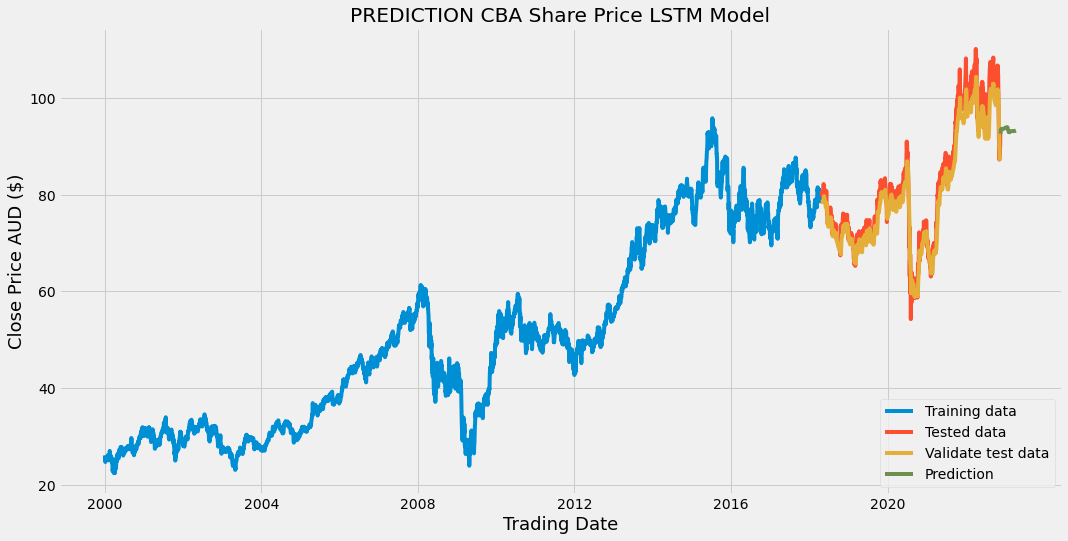

In [41]:
#Plot the data to validate the test data

plt.style.use('fivethirtyeight')
train = new_data.iloc[:train_data_len] # actual train data from 0 rows until train data end
valid = new_data.iloc[train_data_len:df_len] # actual test data from train data end until end of all sampled data
valid['Predictions'] = predictions # another column for validating test
predict = new_data.iloc[df_len:len_pred_df] # user prediction data from loop

plt.figure(figsize=(16,8))
plt.title('PREDICTION CBA Share Price LSTM Model')
plt.xlabel('Trading Date', fontsize=18)
plt.ylabel('Close Price AUD ($)',fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.plot(predict['Close'])
plt.legend(['Training data','Tested data','Validate test data','Prediction'],loc='lower right')
x = np.arange(2000,2024,4)
plt.xticks([0,1000,2000,3000,4000,5000],x)
plt.savefig('../static/data/images/cba_predict_graph.png')
plt.show()

#Save predicted price to MongoDB

In [42]:
# Module used to connect Python with MongoDb
import pymongo

In [43]:
# The default port used by MongoDB is 27017
# https://docs.mongodb.com/manual/reference/default-mongodb-port/
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

# Define the 'sharesDB' database in Mongo
db = client.sharesDB.companys

In [44]:
# query the company collection
companys = db.find()

# see change in collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbaebc940901ee4c7522f2'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 41, 'actual': 42, 'differece': -1, 'rmse': 0.53768}
{'_id': ObjectId('62bbb5d8d8978fe40ad3d64c'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 91, 'actual': 93, 'differece': -2, 'rmse': 0.33103}
{'_id': ObjectId('62bbc7cb193d5e9ca1048e2b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}
{'_id': ObjectId('62bbca7acc73d07c34c73fbb'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 19, 'actual': 19, 'differece': 0, 'rmse': 0.15231}
{'_id': ObjectId('62bbcb598f600c8c92330dad'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 259, 'actual': 274, 'differece': -15, 'rmse': 6.26059}
{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 9

In [45]:
# Query company
# Here, db.companys refers to the collection 'companys '
company_rsme = db.find_one({'name': 'CBA'},{'rsme': 'rsme'})

# Iterate through each company in the collection
for company in company_rsme:
    print(company)

_id
rsme


In [46]:
# Set keys and values of company
name = 'CBA'
predicted = int(pred_price)
difference = pred_price-actual_price
print(f'date {actual_date},predicted {predicted},actual {actual_price}, difference {difference}, rmse {round(rmse,5)}')

date 28/06/2022,predicted 89,actual 93, difference -4, rmse 1.92605


In [47]:
# Delete a document from a collection
db.delete_one(
    {'model': 'LSTM','name': name}
)

In [48]:
# Insert a document into the 'companys' collection
db.insert_one(
    {
      'model': 'LSTM',
      'name': name,
      'date': actual_date,
      'predicted': predicted,
      'actual': actual_price,
      'differece': difference,
      'rmse': round(rmse,5) 
    }
)



In [49]:
# query the companys collection
companys = db.find()

# see change in the collection
for company in companys:
    print(company)

{'_id': ObjectId('62bbaebc940901ee4c7522f2'), 'model': 'LSTM', 'name': 'BHP', 'date': '28/06/2022', 'predicted': 41, 'actual': 42, 'differece': -1, 'rmse': 0.53768}
{'_id': ObjectId('62bbc7cb193d5e9ca1048e2b'), 'model': 'LSTM', 'name': 'NAB', 'date': '28/06/2022', 'predicted': 27, 'actual': 27, 'differece': 0, 'rmse': 0.32984}
{'_id': ObjectId('62bbca7acc73d07c34c73fbb'), 'model': 'LSTM', 'name': 'WBC', 'date': '28/06/2022', 'predicted': 19, 'actual': 19, 'differece': 0, 'rmse': 0.15231}
{'_id': ObjectId('62bbcb598f600c8c92330dad'), 'model': 'LSTM', 'name': 'CSL', 'date': '28/06/2022', 'predicted': 259, 'actual': 274, 'differece': -15, 'rmse': 6.26059}
{'_id': ObjectId('62bbdd4da0c646d0f72fcefa'), 'model': 'RFR', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 97, 'actual': 93, 'differece': 4.07686528417301, 'accuracy': 97.51}
{'_id': ObjectId('62bbde2bba618396dbea2e08'), 'model': 'LSTM', 'name': 'CBA', 'date': '28/06/2022', 'predicted': 89, 'actual': 93, 'differece': -4, 'rmse': 1.9

In [50]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.cba.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/cba.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.cba.insert_one(row)				 				

In [51]:
# # query the collection
# cbas = db.cba.find()

# # see change in collection
# for cba in cbas:
#     print(cba)

In [52]:
# from pymongo import MongoClient
# mongoClient = MongoClient()
# db = mongoClient.sharesDB
# db.cba_scatter.drop()

# import csv
# header = ["Date","Open","High","Low","Close","Adj Close","Volume","SENTIMENT","RBA","FED"]
# csvfile = open('../static/data/cba_scatter.csv', 'r')
# reader = csv.DictReader( csvfile )

# for each in reader:
#     row={}
#     for field in header:
#         row[field]=each[field]
        
#     print (row)
#     db.cba_scatter.insert_one(row)				 				